<a href="https://colab.research.google.com/github/hanzla-khalid98/challenge-2_AN2DL_2025/blob/main/datapreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Challenge 2**

---


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ⚙️ **Libraries Import**

In [9]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu126
Device: cpu


## ⏳ **Data Loading**

In [10]:
!unzip -q "/content/drive/MyDrive/data/an2dl2526c2.zip" -d "/content/drive/MyDrive/data/"


In [11]:
# list of files in train_data
files_train = os.listdir("/content/drive/MyDrive/data/train_data/")

images_train = []
masks_train = []

for file in files_train:
  if file.startswith("img"):
    images_train.append(file)
  elif file.startswith("mask"):
    masks_train.append(file)

# list of files in test_data
files_test = os.listdir("/content/drive/MyDrive/data/test_data/")

images_test = []
masks_test = []

for file in files_test:
  if file.startswith("img"):
    images_test.append(file)
  elif file.startswith("mask"):
    masks_test.append(file)

## 🔎 **Exploration and Data Analysis**

In [13]:
n_image_train = len(images_train)
n_mask_train = len(masks_train)

n_image_test = len(images_test)
n_mask_test = len(masks_test)


print(f"training dataset: {n_image_train} images, {n_mask_train} masks")
print(f"testing dataset: {n_image_test} images, {n_mask_test} masks")

training dataset: 1412 images, 1412 masks
testing dataset: 954 images, 954 masks


In [14]:
df = pd.read_csv("/content/drive/MyDrive/data/train_labels.csv")
df.head()

,sample_index,label
0,img_0000.png,Triple negative
1,img_0001.png,Luminal A
2,img_0002.png,Luminal A
3,img_0003.png,Luminal B
4,img_0004.png,HER2(+)


In [15]:
# label proportions of train_label.csv

labels = df["label"].value_counts()
print(labels)

label
Luminal B          445
Luminal A          414
HER2(+)            397
Triple negative    156
Name: count, dtype: int64


3 classes are balanced but we need to balance the Triple negative class.

In [16]:
root = "/content/drive/MyDrive/data/"

root_train = root + "train_data/"
root_test = root + "test_data/"

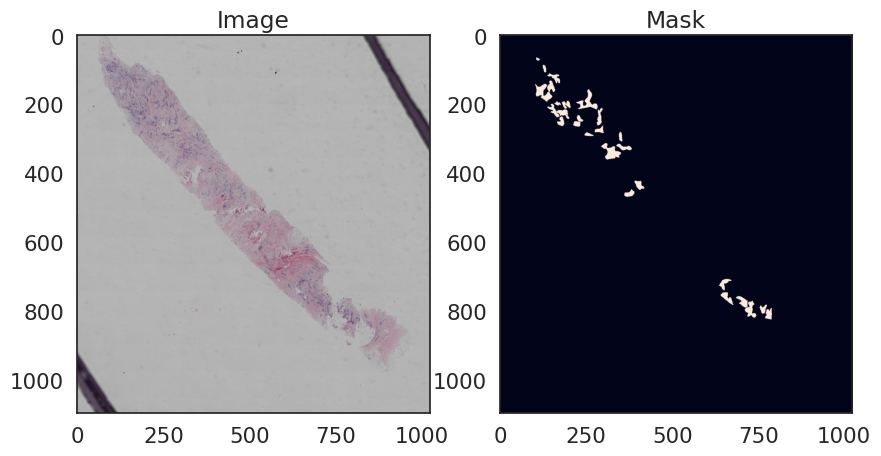

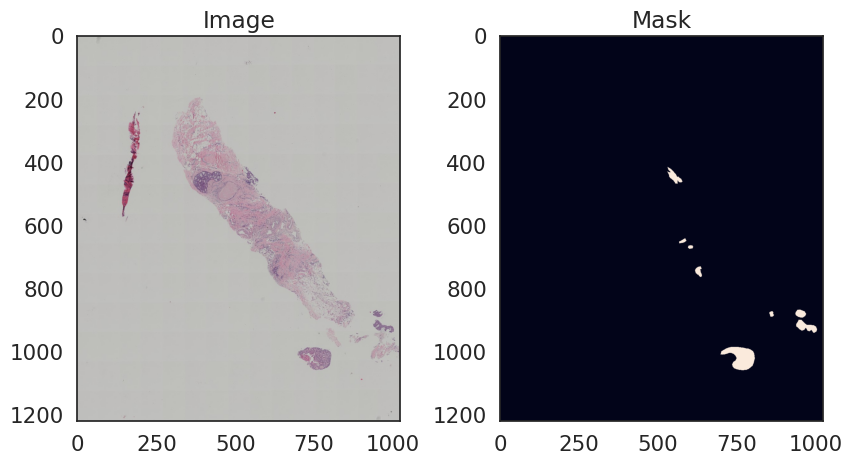

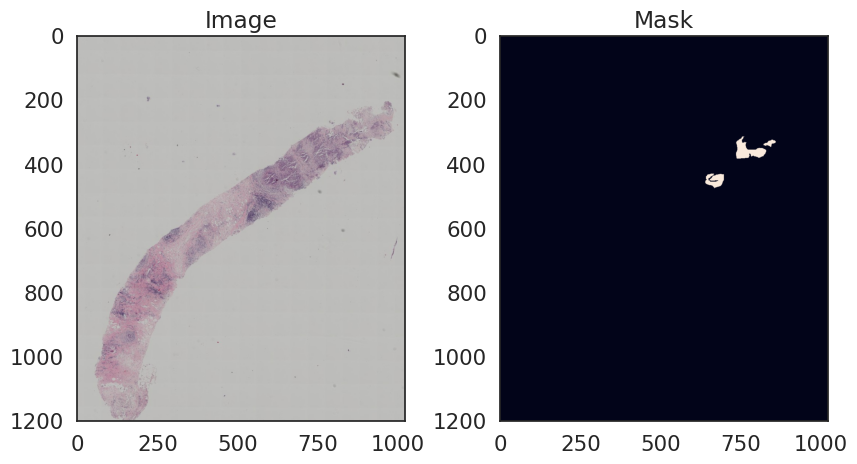

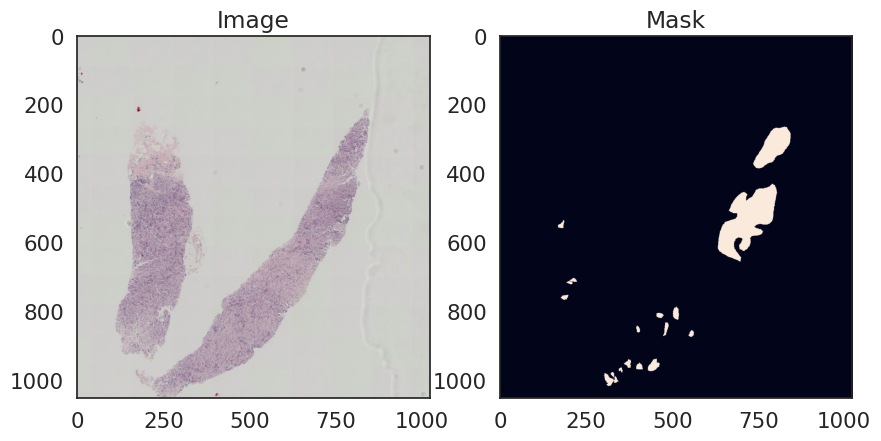

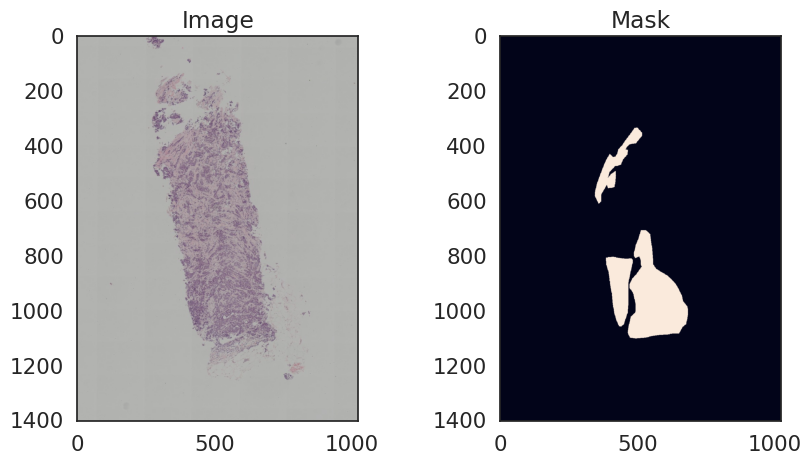

In [17]:
# plot some png images from the train set

# Load the PNG image
for i in range(5):
  image = mpimg.imread(root_train + images_train[i])
  image_number = images_train[i].split("_")[1]
  mask = mpimg.imread(root_train + "mask_" + image_number)
  # Display the image and the mask
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  axs[0].imshow(image)
  axs[0].set_title('Image')
  axs[1].imshow(mask)
  axs[1].set_title('Mask')
  plt.show()


In [20]:
import numpy as np
from PIL import Image

# Define the target size for the images. You can modify this as needed.
TARGET_SIZE = (128, 128) # Example: (height, width)

X_train_val_list = []
X_test_list = []

# Process training images
nb_images_train = len(images_train)
print("Processing training images...")
for i, img_filename in enumerate(images_train):
    if (i + 1) % 100 == 0 or i == 0 or i == nb_images_train - 1:
        print(f"loading training image: {i + 1}/{nb_images_train}")
    img_path = os.path.join(root_train, img_filename)
    img = Image.open(img_path)
    img_resized = img.resize(TARGET_SIZE)
    X_train_val_list.append(np.array(img_resized))
X_train_val = np.array(X_train_val_list)
print(f"X_train_val created with shape: {X_train_val.shape}")
print(f"Each training image is represented as a {TARGET_SIZE[0]}x{TARGET_SIZE[1]} RGB matrix.\n")

# Process testing images
nb_images_test = len(images_test)
print("Processing testing images...")
for i, img_filename in enumerate(images_test):
    if (i + 1) % 100 == 0 or i == 0 or i == nb_images_test - 1:
        print(f"loading testing image: {i + 1}/{nb_images_test}")
    img_path = os.path.join(root_test, img_filename)
    img = Image.open(img_path)
    img_resized = img.resize(TARGET_SIZE)
    X_test_list.append(np.array(img_resized))
X_test = np.array(X_test_list)
print(f"X_test_val created with shape: {X_test.shape}")
print(f"Each testing image is represented as a {TARGET_SIZE[0]}x{TARGET_SIZE[1]} RGB matrix.")

Processing training images...
loading training image: 1/1412
loading training image: 100/1412
loading training image: 200/1412
loading training image: 300/1412
loading training image: 400/1412
loading training image: 500/1412
loading training image: 600/1412
loading training image: 700/1412
loading training image: 800/1412
loading training image: 900/1412
loading training image: 1000/1412
loading training image: 1100/1412
loading training image: 1200/1412
loading training image: 1300/1412
loading training image: 1400/1412
loading training image: 1412/1412
X_train_val created with shape: (1412, 128, 128, 3)
Each training image is represented as a 128x128 RGB matrix.

Processing testing images...
loading testing image: 1/954
loading testing image: 100/954
loading testing image: 200/954
loading testing image: 300/954
loading testing image: 400/954
loading testing image: 500/954
loading testing image: 600/954
loading testing image: 700/954
loading testing image: 800/954
loading testing ima

In [21]:
# Create a mapping from image filename to label using the DataFrame
label_map = df.set_index('sample_index')['label'].to_dict()

# Extract labels for X_train_val based on the order of images_train
y_train_val = np.array([label_map[img_name] for img_name in images_train])

print(f"y_train_val created with shape: {y_train_val.shape}")
print("First 5 labels in y_train_val:", y_train_val[:5])

y_train_val created with shape: (1412,)
First 5 labels in y_train_val: ['Triple negative' 'Luminal A' 'Luminal A' 'Luminal B' 'HER2(+)']


In [22]:
print("Training-Validation Data Shape:", X_train_val.shape)
print("Test Data Shape:", X_test.shape)

Training-Validation Data Shape: (1412, 128, 128, 3)
Test Data Shape: (954, 128, 128, 3)


In [23]:
# Normalize data to the range [0, 1]
X_train_val = (X_train_val / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

In [24]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=SEED, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (1270, 128, 128, 3)
Training Label Shape: (1270,)
Validation Data Shape: (142, 128, 128, 3)
Validation Label Shape: (142,)


In [25]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [31]:
#mapping
class_mapping = {
    "Triple negative": 0,
    "Luminal A": 1,
    "Luminal B": 2,
    "HER2(+)": 3
}

y_train = np.array([class_mapping[label] for label in y_train])
y_val   = np.array([class_mapping[label] for label in y_val])

In [37]:
import torch

train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomErasing(p=1.0, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
])

In [45]:
class AugmentedDataset(torch.utils.data.Dataset):
    """
    Custom PyTorch Dataset that applies data augmentation transforms using transforms v2.

    Following the recommended approach from torchvision documentation:
    - Use ToImage() to convert PIL to tensor
    - Use ToDtype(torch.float32, scale=True) to convert to float and scale to [0, 1]

    Args:
        data (np.ndarray): Input images with shape (N, H, W, C)
        labels (np.ndarray): Labels with shape (N,)
        transform (callable, optional): Transform to apply to images
    """
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

        # Base transform: convert to tensor (following v2 guidelines)
        self.to_tensor = transforms.Compose([
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image and label
        image = self.data[idx]

        # Convert numpy to PIL Image
        image_pil = Image.fromarray((image * 255).astype(np.uint8))

        # Convert to tensor using v2 recommended approach
        image_tensor = self.to_tensor(image_pil)

        # Apply additional transforms if provided
        if self.transform:
            image_tensor = self.transform(image_tensor)

        if self.labels is None:
            return image_tensor
        label = self.labels[idx]

        return image_tensor, torch.tensor(label, dtype=torch.long)


In [47]:
train_ds = AugmentedDataset(X_train, y_train, transform=train_augmentation)
val_ds   = AugmentedDataset(X_val, y_val, transform=None)
test_ds  = AugmentedDataset(X_test, labels=None, transform=None)

AttributeError: module 'torchvision.transforms' has no attribute 'ToImage'

In [48]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 256

In [46]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [ ]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([256, 3, 32, 32])
Labels batch shape: torch.Size([256])
